In [303]:
import cv2
import mediapipe as mp
import pyautogui
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
import time
from keras import Sequential,layers,optimizers,losses,activations
import albumentations as A

In [304]:
x = []
nx = []
y = []

In [305]:
screen_w, screen_h = pyautogui.size()

inpimg = (90,50)

In [306]:
mouse_speed = 0.2
sleep = 0.4

cam = cv2.VideoCapture(0)
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)
pyautogui.hotkey('alt', 'tab')

while True:

    mx = np.random.randint(1,screen_w)
    my = np.random.randint(1,screen_h)
    
    pyautogui.moveTo(mx,my,mouse_speed)
    time.sleep(sleep)
    
    _, frame = cam.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output = face_mesh.process(rgb_frame)
    landmark_points = output.multi_face_landmarks
    frame_h, frame_w, _ = frame.shape
               
    if landmark_points:
        
#         for landmark in [landmarks[159],landmarks[475]]:
#             px = int(landmark.x * frame_w)
#             py = int(landmark.y * frame_h)
#             cv2.circle(frame, (px, py), 2, (255, 255, 255))
            
            
        landmarks = landmark_points[0].landmark
        
        frame1_crop = frame[int(landmarks[257].y * frame_h):int(landmarks[253].y * frame_h), int(landmarks[362].x * frame_w):int(landmarks[359].x * frame_w)]
        frame1_crop = cv2.resize(frame1_crop,(inpimg[0]//2,inpimg[1]//2))
        frame1_crop = cv2.cvtColor(frame1_crop, cv2.COLOR_BGR2GRAY)
        
        frame2_crop = frame[int(landmarks[27].y * frame_h):int(landmarks[23].y * frame_h), int(landmarks[130].x * frame_w):int(landmarks[243].x * frame_w)]
        frame2_crop = cv2.resize(frame2_crop,(inpimg[0]//2,inpimg[1]//2))
        frame2_crop = cv2.cvtColor(frame2_crop, cv2.COLOR_BGR2GRAY)
        
        frame_crop = np.vstack((frame1_crop , frame2_crop))
        frame_crop = np.hstack((frame_crop, cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),(inpimg[0]//2,inpimg[1]))))
        
#         mx, my = pyautogui.position()
        
        x.append(frame_crop)
        nx.append(np.array([landmarks[168].x,landmarks[168].y,landmarks[168].z]))
        y.append(np.array([mx,my]))
        
        print(f"\r{len(x), mx,my , landmarks[168].x,landmarks[168].y,landmarks[168].z}           ", end="")
            
    cv2.imshow('Eye_Tracker', frame_crop)
    k = cv2.waitKey(1)
    
    if k == 27:
        print("\ndone")
        cv2.destroyAllWindows()
        cam.release()
        pyautogui.hotkey('alt', 'tab')
        break

(261, 1237, 117, 0.6074753403663635, 0.3939647674560547, -0.029051896184682846)            
done


In [307]:
cv2.destroyAllWindows()
cam.release()

In [308]:
# x = x[:-10]
# y = y[:-10]
# nx = nx[:-10]

In [309]:
i = 0

0 [ 0.50623393  0.43148503 -0.02759315] [667 241]


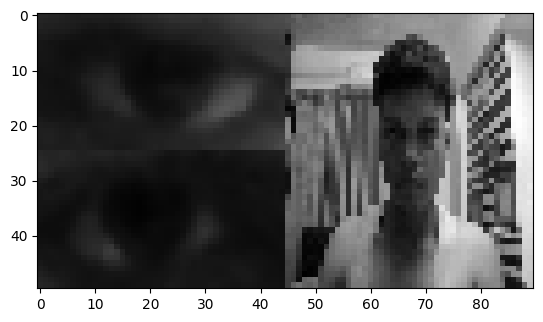

In [310]:
plt.imshow(x[i],cmap="gray")
print(i,nx[i],y[i])
i+=50

In [311]:
dx = np.array(x)
dnx = np.array(nx)
dy = np.array(y)

In [312]:
def random_brightness_contrast(image, alpha_range=(0.5, 1.5), beta_range=(-50, 50)):
    alpha = np.random.uniform(alpha_range[0], alpha_range[1])
    beta = np.random.uniform(beta_range[0], beta_range[1])
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

In [313]:
for curr,i in enumerate(dx):
    print(f"\r{curr}           ",end="")
    for j in range(5):
        dx = np.append(dx,[random_brightness_contrast(i)],axis=0)
        dnx = np.append(dnx,[dnx[curr]],axis=0)
        dy = np.append(dy,[dy[curr]],axis=0)

260           

In [314]:
dx.shape,dy.shape

((1566, 50, 90), (1566, 2))

In [315]:
dy = (dy/[screen_w, screen_h])
dnx = (dnx/[frame_w,frame_h,-1])
dx = dx/255

In [316]:
p = np.random.permutation(dy.shape[0])
dx = dx[p]
dnx = dnx[p]
dy = dy[p]

In [317]:
sp = int(dy.shape[0] * .3)
sp

469

In [318]:
vx = dx[:sp]
vnx = dnx[:sp]
vy = dy[:sp]

tx = dx[sp:]
tnx = dnx[sp:]
ty = dy[sp:]

In [319]:
ty.shape , vy.shape

((1097, 2), (469, 2))

# MODEL

In [320]:
# model = Sequential()

# model.add(layers.Conv2D(16,(3,3),activation=activations.leaky_relu, input_shape = (tx.shape[1],tx.shape[2],1)))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(layers.Conv2D(64,(3,3),activation=activations.leaky_relu))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(layers.Conv2D(64,(3,3),activation=activations.leaky_relu))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(layers.Flatten())

# model.add(layers.Dense(32,activation = activations.leaky_relu))
# model.add(layers.Dense(16,activation = activations.leaky_relu))
# model.add(layers.Dense(2))

# model.summary()

In [321]:
image_input = layers.Input(shape=(tx.shape[1],tx.shape[2],1))
pos_input = layers.Input(shape=(tnx.shape[1],))

conv1 = layers.Conv2D(8,(3,3),activation=activations.leaky_relu)(image_input)
maxp1 = layers.MaxPooling2D((2,2))(conv1)

conv2 = layers.Conv2D(32,(3,3),activation=activations.leaky_relu)(maxp1)
maxp2 = layers.MaxPooling2D((2,2))(conv2)

conv3 = layers.Conv2D(32,(3,3),activation=activations.leaky_relu)(maxp2)
maxp3 = layers.MaxPooling2D((2,2))(conv3)

flat = layers.Flatten()(maxp3)

concat = layers.Concatenate()([flat,pos_input])

dense1 = layers.Dense(32,activation = activations.leaky_relu)(concat)
dense2 = layers.Dense(16,activation = activations.leaky_relu)(dense1)
output = layers.Dense(2)(dense2)

model = Model(inputs = [image_input,pos_input], outputs = output)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 50, 90, 1)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 48, 88, 8)    80          ['input_19[0][0]']               
                                                                                                  
 max_pooling2d_27 (MaxPooling2D  (None, 24, 44, 8)   0           ['conv2d_27[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 22, 42, 32)   2336        ['max_pooling2d_27[0][0]'] 

In [322]:
model.compile(loss = losses.mse , optimizer= optimizers.Adam(0.0001), metrics= ["acc"])

In [323]:
model.fit([tx,tnx],ty,batch_size=16,epochs=50,validation_data=([vx,vnx],vy),shuffle=True)

Epoch 1/50
69/69 [==============================] - 3s 30ms/step - loss: 0.1217 - acc: 0.5378 - val_loss: 0.1036 - val_acc: 0.4712
Epoch 2/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0956 - acc: 0.5150 - val_loss: 0.0955 - val_acc: 0.5373
Epoch 3/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0879 - acc: 0.5825 - val_loss: 0.0871 - val_acc: 0.5160
Epoch 4/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0786 - acc: 0.6281 - val_loss: 0.0716 - val_acc: 0.6546
Epoch 5/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0614 - acc: 0.6964 - val_loss: 0.0678 - val_acc: 0.7783
Epoch 6/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0443 - acc: 0.7803 - val_loss: 0.0385 - val_acc: 0.7228
Epoch 7/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0305 - acc: 0.8186 - val_loss: 0.0296 - val_acc: 0.7207
Epoch 8/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0250 - a

In [327]:
i = 0

1/1 [==============================] - 0s 27ms/step
[0.08831374 0.33915132] [0.15519766 0.37760417]


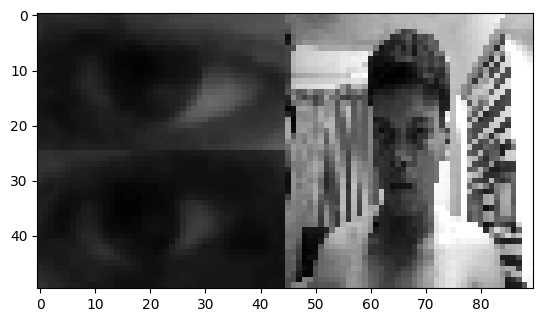

In [328]:
print(model.predict([ np.array([vx[i]]), np.array([vnx[i]]) ])[0], vy[i])
plt.imshow(vx[i],cmap = "gray")
i += 1

In [329]:
pyautogui.FAILSAFE = False

In [330]:
cam = cv2.VideoCapture(0)
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)

while True:
    _, frame = cam.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output = face_mesh.process(rgb_frame)
    landmark_points = output.multi_face_landmarks
    frame_h, frame_w, _ = frame.shape
               
    if landmark_points:
        
#         for landmark in [landmarks[159],landmarks[475]]:
#             px = int(landmark.x * frame_w)
#             py = int(landmark.y * frame_h)
#             cv2.circle(frame, (px, py), 2, (255, 255, 255))
        
        landmarks = landmark_points[0].landmark
        
        frame1_crop = frame[int(landmarks[257].y * frame_h):int(landmarks[253].y * frame_h), int(landmarks[362].x * frame_w):int(landmarks[359].x * frame_w)]
        frame1_crop = cv2.resize(frame1_crop,(inpimg[0]//2,inpimg[1]//2))
        frame1_crop = cv2.cvtColor(frame1_crop, cv2.COLOR_BGR2GRAY)
        
        frame2_crop = frame[int(landmarks[27].y * frame_h):int(landmarks[23].y * frame_h), int(landmarks[130].x * frame_w):int(landmarks[243].x * frame_w)]
        frame2_crop = cv2.resize(frame2_crop,(inpimg[0]//2,inpimg[1]//2))
        frame2_crop = cv2.cvtColor(frame2_crop, cv2.COLOR_BGR2GRAY)
        
        frame_crop = np.vstack((frame1_crop , frame2_crop))
        frame_crop = np.hstack((frame_crop, cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),(inpimg[0]//2,inpimg[1]))))
        
        pos = np.array([landmarks[168].x/frame_w,landmarks[168].y/frame_h,landmarks[168].z/-1])
        
        mx, my = model.predict([np.array([frame_crop/255]), np.array([pos])],verbose=0)[0]
        
        omx = int(mx * screen_w)
        
        omy = int(my * screen_h)
        
        pyautogui.moveTo(omx, omy, duration=0.3)
        
        print(f"\r{mx,my} {omx,omy} {pos}      ", end="")
            
    cv2.imshow('Eye_Tracker', frame_crop)
    
    k = cv2.waitKey(1)
    
    if k == 27:
        print("\ndone")
        cv2.destroyAllWindows()
        cam.release()
        break

(0.1942157, 0.22820003) (265, 175) [0.00079698 0.00084279 0.02036038]         
done


In [46]:
cv2.destroyAllWindows()
cam.release()

# SAVE

In [47]:
path = "C://cllg//nural networks//eyeTracker//"

In [48]:
np.save(path+"x.npy",x)
np.save(path+"nx.npy",nx)
np.save(path+"y.npy",y)

In [49]:
from datetime import datetime

current_datetime = str(datetime.now())
f"{current_datetime.split()[0]}_{current_datetime.split()[1][:8].replace(':','-')}"

'2023-10-12_21-51-28'

In [50]:
model.save(path+"eyeTracker.h5")
model.save(path+f"models//eyeTracker v{current_datetime.split()[0]}_{current_datetime.split()[1][:8].replace(':','-')}.h5")

# LOAD

In [200]:
model = tf.keras.models.load_model(f"{path}eyeTracker.h5")

In [201]:
x = list(np.load(path+"x.npy"))
nx = list(np.load(path+"nx.npy"))
y = list(np.load(path+"y.npy"))